# WS_ch05D.ipynb
# WESmith 11/29/22
## WS created this notebook to follow along with the code in the book:
## 'Bioinformatics with Python Cookbook' by Tiago Antao
## Each recipe will have its own notebook, suffixed by A, B, etc.¶

# RECIPE: 
# EXTRACTING GENES FROM A REFERENCE USING ANNOTATIONS
## also see book code in Chapter05/Getting_Gene.py¶

In [1]:
import os
from collections import defaultdict, OrderedDict  # WS added OrderedDict
import gffutils
from Bio import Seq, SeqIO
import matplotlib.pyplot as plt

In [2]:
# move big files to Downloads so it will not be backed up
data_dir   = '/home/smithw/Downloads/ch05_data'
name_gff   = 'VectorBase-55_AgambiaePEST.gff'
name_fasta = 'VectorBase-57_AgambiaePEST_Genome.fasta'
# ag.db was created in WS_ch05C.ipynb
db_name    = os.path.join(data_dir, 'ag.db')
fasta_name = os.path.join(data_dir, name_fasta)

In [3]:
db = gffutils.FeatureDB(db_name)

### 1) GET GENE ANNOTATION INFORMATION

In [4]:
# voltage-gated sodium channel (VGSC) gene
gene_id = 'AGAP004707'

In [5]:
gene = db[gene_id]
print(gene)

AgamP4_2L	VEuPathDB	protein_coding_gene	2358158	2431617	.	+	.	ID=AGAP004707;Name=para;description=voltage-gated sodium channel


In [6]:
print(gene.seqid, gene.strand)

AgamP4_2L +


### 2) GET THE SEQUENCE OF THE CHROMOSOME CONTAINING THE GENE

In [7]:
recs = SeqIO.parse(open(fasta_name, 'rt', encoding='utf-8'), 'fasta')
for rec in recs:
    print(rec.description)
    if rec.id == gene.seqid:
        my_seq = rec.seq
        break

AgamP4_2L | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=49364325 | SO=chromosome


In [8]:
my_seq  # WS sequence for entire chromosome 2L

Seq('AACCATGGTCCAGAGTACACATTGACTATGCAGGCCTAGTAGACGAATTCTACT...AAA')

### 3) CONSTRUCT A FUNCTION TO RETURN A SEQUENCE FROM A LIST OF CDS

In [9]:
# WS added 'offset' to generalize to different phases
def get_sequence(chrom_seq, CDSs, strand, offset=0):
    # WS CDSs should work as a generator or a list
    seq = Seq.Seq('')
    for CDS in CDSs:
        # #FRAME???
        my_cds = Seq.Seq(str(chrom_seq[CDS.start - 1 + offset: CDS.end + offset]))
        seq += my_cds
    return seq if strand == '+' else seq.reverse_complement()

### 4) CHOOSE AN mRNA TRANSCRIPT FOR THE GENE FROM THOSE AVAILABLE

In [10]:
mRNAs = db.children(gene, featuretype='mRNA') # returns a generator

In [11]:
for mRNA in mRNAs:
    print(mRNA.id)
    if mRNA.id.endswith('RA'): # WS why choose 'RA'?
        break

AGAP004707-RA


In [12]:
print(mRNA)

AgamP4_2L	VEuPathDB	mRNA	2358158	2431617	.	+	.	ID=AGAP004707-RA;Parent=AGAP004707;description=voltage-gated sodium channel


### 5) GET THE CDSs FOR THIS PARTICULAR mRNA TRANSCRIPT,
### THEN THE NUCLEOTIDE SEQUENCE THEY REPRESENT, 
### THEN THE PROTEIN

In [13]:
CDSs = db.children(mRNA, featuretype='CDS', order_by='start')
CDS_list = list(CDSs)   #WS turn generator into a list to examine

In [14]:
len(CDS_list)  
# I counted 30 CDSs for the 'RA' mRNA parent directly from the gff 
# file using emacs: correct

30

In [15]:
CDS_list[0].__dict__

{'seqid': 'AgamP4_2L',
 'source': 'VEuPathDB',
 'featuretype': 'CDS',
 'start': 2358158,
 'end': 2358304,
 'score': '.',
 'strand': '+',
 'frame': '0',
 'attributes': <gffutils.attributes.Attributes at 0x7f02fdc72d40>,
 'extra': [],
 'bin': 4698,
 'id': 'AGAP004707-PA-CDS1',
 'dialect': {'leading semicolon': False,
  'trailing semicolon': False,
  'quoted GFF2 values': False,
  'field separator': ';',
  'keyval separator': '=',
  'multival separator': ',',
  'fmt': 'gff3',
  'repeated keys': False,
  'order': ['ID', 'description', 'Parent', 'gene_id', 'protein_source_id']},
 'file_order': 89260,
 'keep_order': False,
 'sort_attribute_values': False}

In [16]:
gene_seq = get_sequence(my_seq, CDS_list, gene.strand) # WS sending in a list

In [17]:
print(len(gene_seq), gene_seq)

6195 ATGACCGAAGACTCCGATTCGATATCTGAGGAAGAACGTAGTTTGTTCCGTCCTTTCACTCGTGAATCATTACAAGCTATCGAAGCACGCATTGCAGATGAAGAAGCCAAACAGCGAGAATTGGAAAGAAAACGAGCTGAGGGGGAGATACGCTACGATGACGAGGATGAGGATGAAGGTCCCCAACCGGACCCTACTCTTGAACAGGGTGTACCAGTCCCAGTTCGAATGCAAGGCAGCTTCCCCCCGGAGTTGGCCTCCACGCCTCTCGAGGATATTGACAGTTTCTATTCAAATCAAAGGACATTCGTAGTGATTAGTAAAGGAAAAGATATATTTCGTTTCTCCGCAACTAACGCATTATATGTACTTGATCCGTTTAACCCCATACGCCGCGTAGCTATTTATATTTTAGTACATCCACTGTTTTCACTTTTTATAATAACGACCATTCTTGTTAATTGTATATTGATGATTATGCCTACCACGCCGACAGTCGAATCTACCGAGGTGATATTCACCGGCATCTACACGTTCGAATCAGCTGTAAAAGTGATGGCGCGAGGTTTCATATTACAACCGTTTACTTATCTTAGAGATGCATGGAATTGGTTGGACTTCGTAGTAATAGCATTAGCATATGTAACTATGGGTATAGATTTGGGTAATCTTGCTGCGTTGAGAACATTCAGGGTATTACGAGCTCTTAAAACGGTAGCCATCGTTCCAGGCTTAAAAACCATCGTCGGAGCCGTTATAGAATCCGTAAAGAATCTCAGAGATGTGATAATTTTAACAATGTTTTCGTTATCCGTGTTTGCTTTGATGGGTCTACAAATCTACATGGGAGTACTAACACAAAAGTGCATAAAAGAGTTCCCATTGGATGGTTCCTGGGGTAATCTAACCGACGAAAGCTGGGAGCTGTTCAACAGCAATGACACAAATTGGTTCTATTCCGAGAGTGGCGACATTCCTCTTTGTGGAAACTCATC

In [18]:
prot = gene_seq.translate()
print(len(prot), prot)

2065 MTEDSDSISEEERSLFRPFTRESLQAIEARIADEEAKQRELERKRAEGEIRYDDEDEDEGPQPDPTLEQGVPVPVRMQGSFPPELASTPLEDIDSFYSNQRTFVVISKGKDIFRFSATNALYVLDPFNPIRRVAIYILVHPLFSLFIITTILVNCILMIMPTTPTVESTEVIFTGIYTFESAVKVMARGFILQPFTYLRDAWNWLDFVVIALAYVTMGIDLGNLAALRTFRVLRALKTVAIVPGLKTIVGAVIESVKNLRDVIILTMFSLSVFALMGLQIYMGVLTQKCIKEFPLDGSWGNLTDESWELFNSNDTNWFYSESGDIPLCGNSSGAGQCDEGYICLQGYGKNPNYGYTSFDTFGWAFLSAFRLMTQDYWENLYQLVLRSAGPWHMLFFIVIIFLGSFYLVNLILAIVAMSYDELQKKAEEEEAAEEEALREAEEAAAAKAAKLEAQQAAAAAAANPEIAKSPSDFSCHSYELFVGQEKGNDDNNKEKMSIRSEGLESVSEITRTTAPTATAAGTAKARKVSAFTIRNGRGRFVGVPGSDRKPLVLSTYLDAQEHLPYADDSNAVTPMSEENGAIIVPVYYANLGSRHSSYTSHQSRISYTSHGDLLGGMTKESRLRNRSARNTNHSIVPPPNANNLSYAETNHKGQRDFDLTQDCTDDAGKIKHNDNPFIEPAQTQTVVDMKDVMVLNDIIEQAAGRHSRASDHGVSVYYFPTEDDDEDGPTFKDKALEFLMKMIDIFCVWDCCWVWLKFQEWVAFIVFDPFVELFITLCIVVNTLFMALDHHDMDPDMEKALKSGNYFFTATFAIEATMKLIAMSPKYYFQEGWNIFDFIIVALSLLELGLEGVQGLSVLRSFRLLRVFKLAKSWPTLNLLISIMGRTMGALGNLTFVLCIIIFIFAVMGMQLFGKNYVDNVDRFPDHDLPRWNFTDFMHSFMIVFRVLCGEWIESMWDCMLVGDVSCIPFFLATVVIGNLVVLNLFLALLLSNFG

### 6) GET GENE CODED IN NEGATIVE STRAND DIRECTION

In [19]:
reverse_gene_id = 'AGAP004708'  # WS added gene-level stuff
reverse_gene = db[reverse_gene_id]

In [20]:
print(reverse_gene.seqid, reverse_gene.strand) # explicitly shows '-'

AgamP4_2L -


In [21]:
reverse_transcript_id = 'AGAP004708-RA'

In [22]:
reverse_CDSs = list(db.children(reverse_transcript_id, featuretype='CDS', 
                                order_by='start'))

In [23]:
for k in reverse_CDSs:  # WS print
    print(k.id, k.start)

AGAP004708-PA-CDS5 2471997
AGAP004708-PA-CDS4 2472199
AGAP004708-PA-CDS3 2472577
AGAP004708-PA-CDS2 2473705
AGAP004708-PA-CDS1 2474117


In [24]:
reverse_seq = get_sequence(my_seq, reverse_CDSs, '-')

In [25]:
print(len(reverse_seq), reverse_seq)

1992 ATGGCTGACTTCGATAGTGCCACTAAATGTATCAGAAACATTGAAAAAGAAATTCTTCTCTTGCAATCCGAAGTTTTGAAGACTCGTGAGGGGCTTGGGCTGGAAGATGATAACGTGGAACTTAAAAAGTTAATGGAGGAAAACACGAGATTAAAGCATCGTTTGGAGATAGTGCAATCGGCTATTGTACAGGAAGGCGGATCAATCGCATCCTCCGATTCTGGCAACCAATCCATTGTTGGCGAACTGCAGCAAGTATTTACCGAAGCCATTCAAAAAGCTTTTCCAAGTGTGTTGGTTGAGGCGGTTATTACTATTTCGTCATCCCCCAAGTTTGGCGATTATCAATGCAATAGTGCTATGCAGATTGCGCAGCATTTGAAGCAGTTATCTGTTAAATCGTCGCCACGTGAAGTGGCCCAAAAACTGGTAGCTGAATTGCAAAAACCAATACCTTGTGTCGATAGATTAGAAATCGCTGGAGCGGGATACGTTAATATTTTCCTGTCTAGATCTTATGGAGAACAACGCATTATGAGCATCTTGAGGCATGGGATTGTGGTACCATTAATAGAAAAGAAACGTGTGATAGTCGATTTTTCCTCGCCTAACGTAGCGAAAGAAATGCATGTCGGTCATTTACGTTCGACCATCATTGGTGATTCAATTTGTCGATTTTTGGAATATCTCGGACACGATGTGCTTCGTATTAACCATATCGGAGACTGGGGAACGCAATTTGGTATGTTAATTGCTCATTTGCAGGACCGTTTCCCTAATTTCCAAACCGAGTCCCCGCCTATCAGCGATTTGCAAGCATTTTACAAGGAGTCAAAGGTCCGATTTGACAGCGATGAAGTATTTAAAAAGCGTGCCTACGAATGTGTAGTCAAACTGCAAAGTGGAGAGCTGAGTTATTTGAAGGCCTGGAATCTAATTTGCGATGTTTCACGCAAAGAATTCCAAACCATCTACAACAGATTGGATGTGAAACT

In [26]:
reverse_prot = reverse_seq.translate()
print(len(reverse_prot), reverse_prot)

664 MADFDSATKCIRNIEKEILLLQSEVLKTREGLGLEDDNVELKKLMEENTRLKHRLEIVQSAIVQEGGSIASSDSGNQSIVGELQQVFTEAIQKAFPSVLVEAVITISSSPKFGDYQCNSAMQIAQHLKQLSVKSSPREVAQKLVAELQKPIPCVDRLEIAGAGYVNIFLSRSYGEQRIMSILRHGIVVPLIEKKRVIVDFSSPNVAKEMHVGHLRSTIIGDSICRFLEYLGHDVLRINHIGDWGTQFGMLIAHLQDRFPNFQTESPPISDLQAFYKESKVRFDSDEVFKKRAYECVVKLQSGELSYLKAWNLICDVSRKEFQTIYNRLDVKLVERGESFYQSRMEKIVEELKQDGFLEEDEGRLIMWGENRAGIPLTIVKSDGGFTYDTSDMAAIKQRLQEEKADWLIYVTDAGQATHFQTIFSCAKRAKILQESKHRVDHVGFGVVLGEDGKKFKTRSGDTVKLTELLNEGLRRAMEKLVQKERNLVLTQEELVAAQESVAYGCIKYADLSHNRNNEYVFSFDKMLEDKGNTAVYLLYAYTRIRSIARKCGGDFANDMQKVIDSTVIKLDHEKEWKLAKVLLRFTDVMLLIMKNLSLHHLCEFVYEICTAFSEFYDSCYCIEKNKQGEIITVYPSRVLLCEATSKVLEKCFDILGLKPVHKI*


### WS EXPERIMENTS

In [27]:
# WS NEXT1: find the stop codon in the above;
# then look at the other 5 frames for this sequence, and count the stop
# codons; the correct sequence only has 1 stop codon?

In [28]:
# look at the genetic code to see stop codons
from Bio.Data import CodonTable
standard_table = CodonTable.unambiguous_dna_by_id[1]
mito_table     = CodonTable.unambiguous_dna_by_id[2]
print(standard_table)

Table 1 Standard, SGC0

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I   | ACT T   | AAT N   | AGT S   | T
A | ATC I   | ACC T   | AAC N   | AGC S   | C
A | ATA I   | ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V   | GCG A   | GAG E   | GGG G   | G
--+---------

In [29]:
# WS function to generate the histogram of a protein sequence
def amino_histo(seq, order=False):
    num_amino = defaultdict(int)
    #num_amino = OrderedDict()
    for k in seq:
        num_amino[k] += 1
        #num_amino[k] = num_amino.get(k, 0) + 1
    if order:
        amino_list = list(num_amino.keys())
        amino_list.sort()
        return {k: num_amino[k] for k in amino_list}
    return num_amino

In [30]:
ordered_prot_hist = amino_histo(prot, order=True)
for j, k in ordered_prot_hist.items():
    print('amino acid {} occurs {:4} times'.format(j, k))

amino acid * occurs    1 times
amino acid A occurs  143 times
amino acid C occurs   34 times
amino acid D occurs  141 times
amino acid E occurs  126 times
amino acid F occurs  130 times
amino acid G occurs  142 times
amino acid H occurs   34 times
amino acid I occurs  157 times
amino acid K occurs  105 times
amino acid L occurs  195 times
amino acid M occurs   69 times
amino acid N occurs   98 times
amino acid P occurs   82 times
amino acid Q occurs   65 times
amino acid R occurs   83 times
amino acid S occurs  133 times
amino acid T occurs  101 times
amino acid V occurs  129 times
amino acid W occurs   32 times
amino acid Y occurs   65 times


In [31]:
list(range(-3,3))

[-3, -2, -1, 0, 1, 2]

In [32]:
# WS now look at all 6 frames (+,- complement for 3 phases) and see how many stop ('*') codons show up per case
# the 'true' '+' strand with zero offset should show only 1 stop codon (as per the Cell book)
x1 = ['+', '-']
x2 = list(range(-3,4))
vals = [(x,y) for x in x1 for y in x2]
for (j, k) in vals:
    ss = get_sequence(my_seq, CDS_list, j, offset=k)
    dd = ss.translate()
    out = amino_histo(dd)
    print('strand: {}, phase: {:2}, number of stop signals: {:4}'.format(j, k, out['*']))
# only 1 combination is showing 1 stop signal
# NOTE: not clear why +3 offset isn't showing at most 2 stop siglals: original and possibly another one at new end
#       and why -3 offset isn't showing at most 1 stop (it loses the one at the end, and picks up at most 1 at the
#       new beginning): 
# POSSIBLE SOLUTION: we're concatenating CDS sections, and reading each CDS with the same offset, so they are going
#                    together in complex ways: we're not offsetting a single strand, but multiple concatenated
#                    strands; the ONLY case with the single 'stop' is the '+' strand with 0 offset on all of the CDSs

strand: +, phase: -3, number of stop signals:    4
strand: +, phase: -2, number of stop signals:  145
strand: +, phase: -1, number of stop signals:  141
strand: +, phase:  0, number of stop signals:    1
strand: +, phase:  1, number of stop signals:  143
strand: +, phase:  2, number of stop signals:  142
strand: +, phase:  3, number of stop signals:    3
strand: -, phase: -3, number of stop signals:   99
strand: -, phase: -2, number of stop signals:  131
strand: -, phase: -1, number of stop signals:   76
strand: -, phase:  0, number of stop signals:   99
strand: -, phase:  1, number of stop signals:  130
strand: -, phase:  2, number of stop signals:   77
strand: -, phase:  3, number of stop signals:   97


In [33]:
sss = get_sequence(my_seq, CDS_list, '+', offset=0)
dd = sss.translate()
amino_histo(dd, order=True)

{'*': 1,
 'A': 143,
 'C': 34,
 'D': 141,
 'E': 126,
 'F': 130,
 'G': 142,
 'H': 34,
 'I': 157,
 'K': 105,
 'L': 195,
 'M': 69,
 'N': 98,
 'P': 82,
 'Q': 65,
 'R': 83,
 'S': 133,
 'T': 101,
 'V': 129,
 'W': 32,
 'Y': 65}

In [34]:
# WS now look at reverse complement of '+' thread and see how many stop ('*') codons show up
gene_seq

Seq('ATGACCGAAGACTCCGATTCGATATCTGAGGAAGAACGTAGTTTGTTCCGTCCT...TGA')

In [35]:
reverse_gene_seq = gene_seq.reverse_complement()
reverse_gene_seq

Seq('TCAGACATCTGCCGTTCGCGATGTTATGCTGGGAGATCGAGAGTGTATGACGAC...CAT')

In [36]:
reverse_gene_seq_prot = reverse_gene_seq.translate()

In [37]:
ordered_reverse_prot_hist = amino_histo(reverse_gene_seq_prot, order=True)
for j, k in ordered_reverse_prot_hist.items():
    print('amino acid {} occurs {:4} times'.format(j, k))  # WS this gets a 'stop' 99 times: obviously bogus

amino acid * occurs   99 times
amino acid A occurs   79 times
amino acid C occurs   88 times
amino acid D occurs   61 times
amino acid E occurs   84 times
amino acid F occurs  157 times
amino acid G occurs   70 times
amino acid H occurs  109 times
amino acid I occurs  185 times
amino acid K occurs  100 times
amino acid L occurs  139 times
amino acid M occurs   17 times
amino acid N occurs   96 times
amino acid P occurs   50 times
amino acid Q occurs   74 times
amino acid R occurs  121 times
amino acid S occurs  154 times
amino acid T occurs  124 times
amino acid V occurs  136 times
amino acid W occurs   33 times
amino acid Y occurs   89 times


In [38]:
# WS NEXT2: look at another mRNA version (say 'RB') and calculate its
# protein structure and compare: create a single function to do this?

In [39]:
#gene_id = 'AGAP004707' # doesn't have 3', 5' for plot testing, has many mRNAs
#gene_id = 'AGAP003566' # has 3', 5' for plot testing: good example, works; only 1 mRNA though
gene_id = 'AGAP010865' # has 2 mRNAs, exons, cds's, utr's: good for testing plot routine
gene = db[gene_id]
gene.start, gene.stop

(12139871, 12155328)

In [40]:
# WS go thru all of the CDSs and extract the ones with the desired parent mRNA
def get_child_of_parent(parent, feature):
    return list(db.children(parent, featuretype=feature))

In [109]:
def get_object_coords(obj, y_offset, name='', scale=1): # WS
    out = []
    for k in obj:
        #print(k.id, k.start, k.stop, y_offset)  # WS diagnostic
        out.append([(k.start/scale, k.stop/scale), (y_offset, y_offset), name])
    return out

In [110]:
def plot_mRNA_exon_cds(obj, y_offset, scale=1, delta=0.02): # WS
    out = [[(obj.start, obj.stop), (y_offset, y_offset), obj.id]]
    #print('mRNA: ', obj.id, obj.start, obj.stop, y_offset)  # WS diagnostic
    y_offset -= delta

    exon      = get_child_of_parent(obj, 'exon')
    cds       = get_child_of_parent(obj, 'CDS')
    utr_five  = get_child_of_parent(obj, 'five_prime_UTR')
    utr_three = get_child_of_parent(obj, 'three_prime_UTR')

    out.extend(get_object_coords(exon, y_offset, scale=scale, name='exon'))
    y_offset -= delta
    out.extend(get_object_coords(cds, y_offset, scale=scale, name='CDS'))
    y_offset -= delta
    out.extend(get_object_coords(utr_five, y_offset, scale=scale, name="5'-UTR"))
    y_offset -= delta
    out.extend(get_object_coords(utr_three, y_offset, scale=scale, name="3'-UTR"))
    return out

In [166]:
def plot_all_sequences(db, gene_id, y_offset=1, scale=1, delta=0.02, mRNAdelta=0.12):
    '''
    db  derived from a gff version 3 file using gffutils:
        eg: db = gffutils.create_db(gff3_file, saved_db) to create it and load into memory as 'db'
            db = gffutils.FeatureDB(saved_db) to load existing saved_db into memory as 'db'
    '''
    gene = db[gene_id]
    txt = '{}\nstrand: {}'.format(gene_id, gene.strand)
    out = [[(gene.start/scale, gene.stop/scale), (y_offset, y_offset), txt]]
    #print('gene: ', gene.id, gene.start, gene.stop, y_offset)  # WS diagnostic
    y_offset -= 5 * delta  # separate the gene from the mRNA below it
    mRNAs = get_child_of_parent(gene, 'mRNA')
    for mRNA in mRNAs:
        out.extend(plot_mRNA_exon_cds(mRNA, y_offset, scale=scale, delta=delta))
        y_offset -= mRNAdelta  # separate the mRNA graphics from each other
    return out

In [167]:
#out = plot_mRNA_exon_cds(mRNA, 0, 0.9, maxx)
#out = plot_all_sequences(db, gene_id)

In [168]:
# WS create a simple graph of gff information using matplotlib
def plot_gene(db, gene_id, w=7, lmarg=0.15, rmarg=0.05, xwin=16, ywin=6):
    out = plot_all_sequences(db, gene_id)
    xmin, xmax = out[0][0]
    ymin = out[-1][1][0]
    ymax = out[0][1][0]
    xdel = xmax - xmin
    xmin = xmin - lmarg * xdel
    xmax = xmax + rmarg * xdel
    ydelta = 0.05
    
    fig, axs = plt.subplots(1, 1, figsize=(xwin, ywin))
    for k in out:
        axs.plot(k[0], k[1], linewidth=w)
        axs.text(xmin + 0.01 * xdel, k[1][0], k[2], fontsize='large')
    axs.grid()

    axs.set_xlim(xmin, xmax)
    axs.set_ylim(ymin - ydelta, ymax + ydelta)
    txt = 'GENE {}'.format(gene_id)
    axs.set_title(txt)
    plt.show()
    return out  # WS for diagnostics

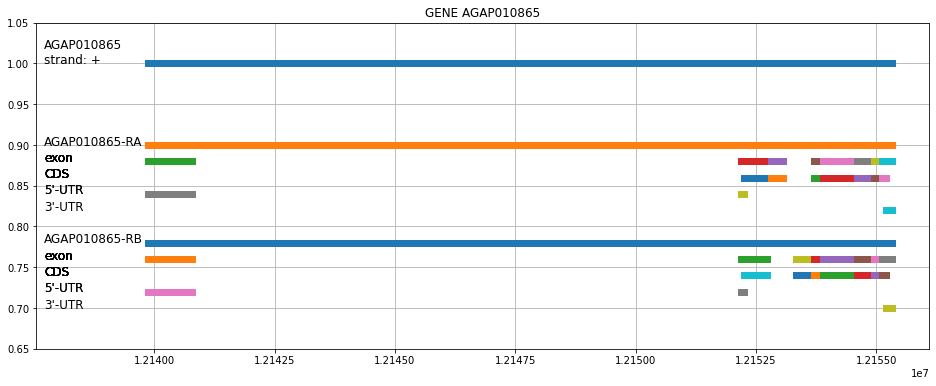

In [169]:

#gene_id = 'AGAP003566' # has 3', 5' for plot testing: good example, works; only 1 mRNA though
gene_id = 'AGAP010865' # has 2 mRNAs, exons, cds's, utr's: good for testing plot routine
out = plot_gene(db, gene_id)

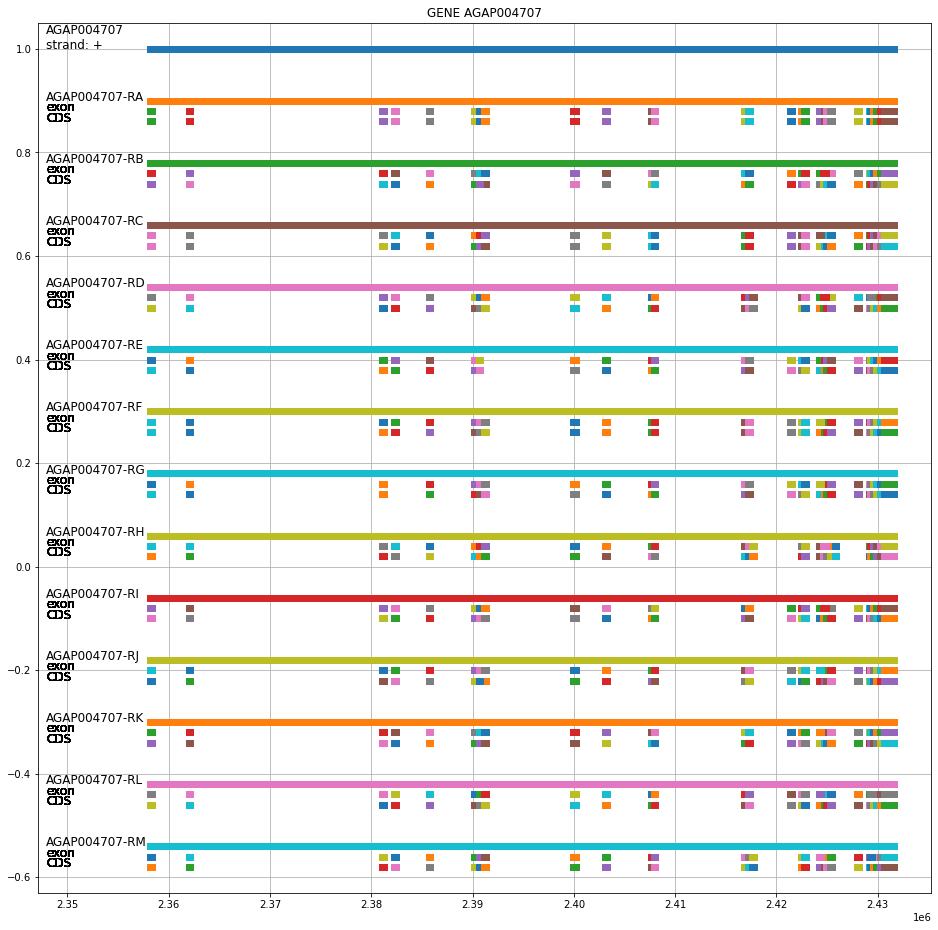

In [170]:
gene_id = 'AGAP004707' # doesn't have 3', 5' for plot testing, has many mRNAs
out = plot_gene(db, gene_id, xwin=16, ywin=16)

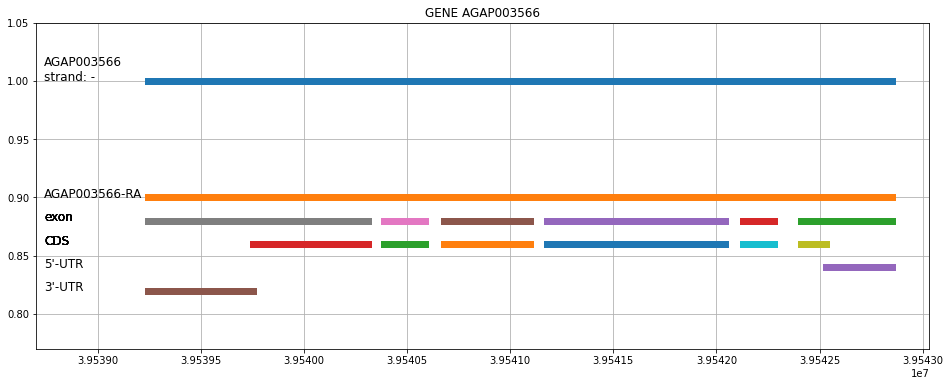

In [171]:
gene_id = 'AGAP003566' # has 3', 5' for plot testing: good example, works; only 1 mRNA though
out = plot_gene(db, gene_id)

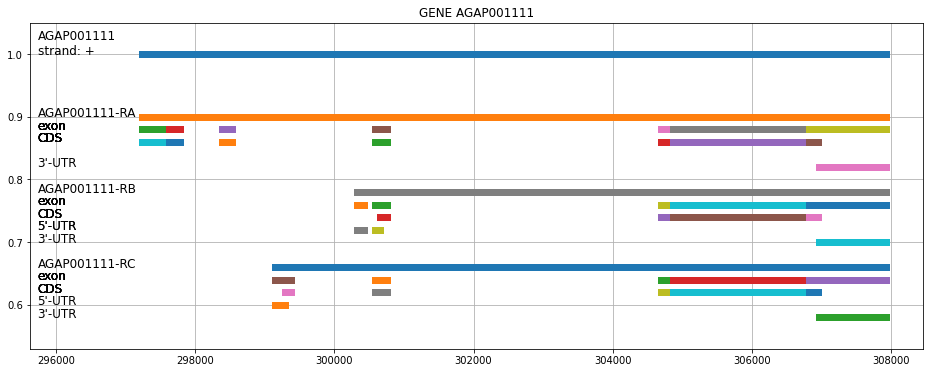

In [173]:
gene_id = 'AGAP001111'
out = plot_gene(db, gene_id)

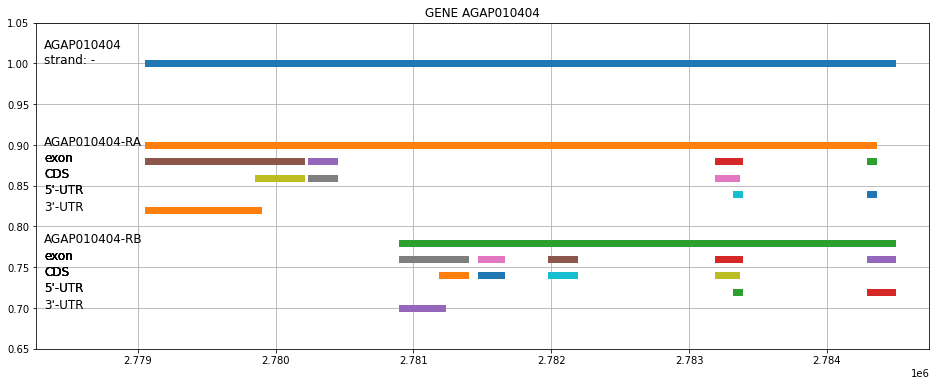

In [193]:
gene_id = 'AGAP010404'
out = plot_gene(db, gene_id)

In [201]:
class PlotGFF():
    def __init__(self, db, gene_id, w=7, y_offset=1, lmarg=0.15, rmarg=0.05, 
                 tmarg=0.05, bmarg=0.2, xwin=16, ywin=6, txtoff=0.01, scale=1, 
                 sep=0.02, mRNA_sep=0.12, gene_sep=0.1):
        '''
        db  derived from a gff version 3 file using gffutils:
            eg: db = gffutils.create_db(gff3_file, saved_db) to create it and load into memory as 'db'
                db = gffutils.FeatureDB(saved_db) to load existing saved_db into memory as 'db'
        '''  
        self.db       = db       # gff3 database produced using gffutils
        self.gene_id  = gene_id  # gene ID as per gff convention
        self.w        = w        # width of sequence line in vertical direction
        self.y_offset = y_offset # vertical location of primary gene in the figure
        self.lmarg    = lmarg    # left   margin of figure
        self.rmarg    = rmarg    # right  margin of figure
        self.tmarg    = tmarg    # top    margin of figure
        self.bmarg    = bmarg    # bottom margin of figure
        self.xwin     = xwin     # width  of figure
        self.ywin     = ywin     # height of figure
        self.txtoff   = txtoff   # offset for inline text before sequence graphic
        self.scale    = scale    # defaults to 1, not needed at present
        self.sep      = sep      # vertical separation between exon, CDS, UTRs within mRNA group
        self.mRNA_sep = mRNA_sep # vertical separation between different mRNA groups
        self.gene_sep = gene_sep # vertical separation from chromosome and first mRNA


    def plot_all_sequences(self):
        gene = self.db[self.gene_id]
        txt = '{}\nstrand: {}'.format(self.gene_id, gene.strand)
        self.out = [[(gene.start/self.scale, gene.stop/self.scale), (self.y_offset, self.y_offset), txt]]
        #print('gene: ', gene.id, gene.start, gene.stop, y_offset)  # WS diagnostic
        self.y_offset -= self.gene_sep  # separate the gene from the mRNA below it
        mRNAs = get_child_of_parent(gene, 'mRNA')
        for mRNA in mRNAs:
            self.out.extend(plot_mRNA_exon_cds(mRNA, self.y_offset, scale=self.scale, delta=self.sep))
            self.y_offset -= self.mRNA_sep  # separate the mRNA graphics from each other   


    def plot(self):
        self.plot_all_sequences()
        xmin, xmax = self.out[0][0]
        ymin = out[-1][1][0]
        ymax = out[0][1][0]
        xdel = xmax - xmin
        xmin = xmin - self.lmarg * xdel
        xmax = xmax + self.rmarg * xdel

        fig, axs = plt.subplots(1, 1, figsize=(self.xwin, self.ywin))
        for k in self.out:
            axs.plot(k[0], k[1], linewidth=self.w)
            axs.text(xmin + self.txtoff * xdel, k[1][0], k[2], fontsize='large')
        axs.grid()

        axs.set_xlim(xmin, xmax)
        axs.set_ylim(ymin - self.bmarg, ymax + self.tmarg)
        txt = 'GENE {}'.format(self.gene_id)
        axs.set_title(txt)
        plt.show()

In [202]:
dd = PlotGFF(db, gene_id)

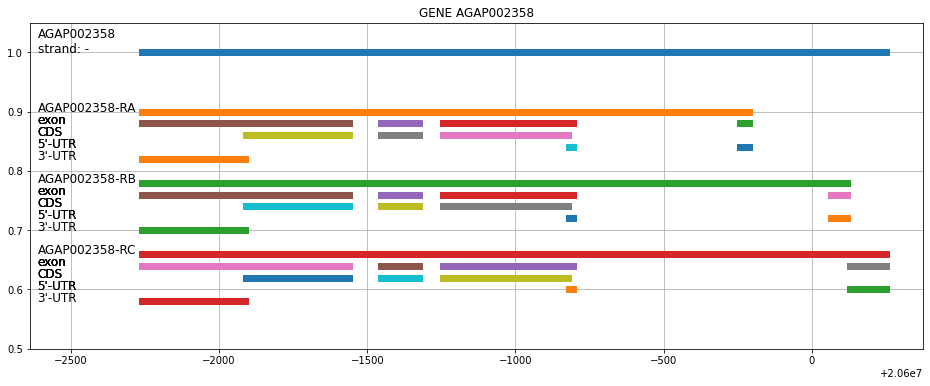

In [203]:
dd.plot()

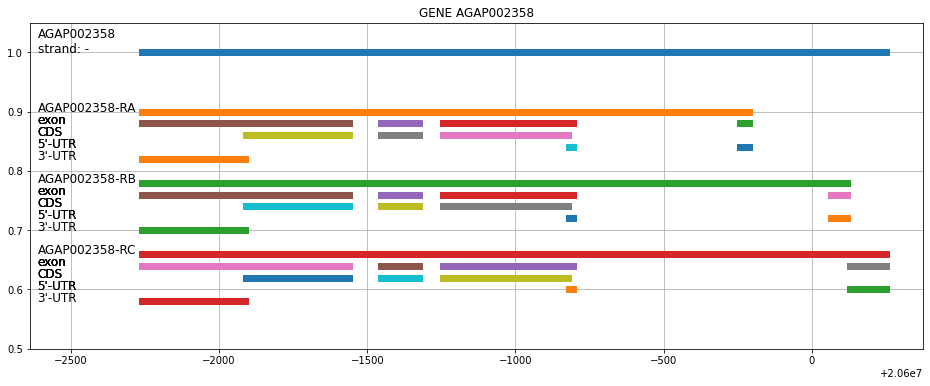

In [204]:
gene_id = 'AGAP002358'
dd = PlotGFF(db, gene_id)
dd.plot()

In [ ]:
# next: put class and associated functions in ws_utils.py